In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
# Importamos utilidades y modelos de sklearn
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


# Se levanta el set de train generado

In [2]:
data_set = pd.read_csv("train_set_xgb.csv")
#X = data_set.loc[:, (data_set.columns != 'precio') & (data_set.columns != 'factor_pm')]
X = data_set.loc[:, (data_set.columns != 'precio')]
y = data_set.loc[:, ['precio']]

In [3]:
data_set.columns

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio',
       'anio_publ'],
      dtype='object')

In [4]:
X.columns

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos',
       'anio_publ'],
      dtype='object')

In [5]:
y.columns

Index(['precio'], dtype='object')

# Se separa en train y en test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [7]:
len(X_train)

168000

In [8]:
len(X_test)

72000

## Armamos el dataset sobre el cual cada XGBoost va a subsamplear con reposición.

### Esto se hace sobre el X_train con su respectivo label.

In [9]:
data_for_xgb = pd.concat([X_train, y_train], axis = 1)
data_for_xgb.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,anio_publ,precio
239101,0.0,3.0,2.0,3.0,196.0,160.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2014,1800000.0
96221,20.0,4.0,2.0,2.0,245.0,196.0,104734.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,2012,1500000.0
144453,5.0,3.0,1.0,2.0,108.0,120.0,58952.0,NaN,NaN,0.0,0.0,0.0,1.0,1.0,2015,850000.0
15620,10.0,3.0,1.0,3.0,200.0,147.0,49066.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2016,1550000.0
73157,NaN,NaN,0.0,NaN,NaN,250.0,24892.0,19.23339,-99.166992,0.0,0.0,0.0,0.0,0.0,2016,700000.0


### En principio el subsample será de igual tamaño que el X_train original pero va a tener repeticiones.
### Habra que comprobar si no conviene uno de menor tamaño

# XGB_1

In [10]:
d_for_xgb_1 = data_for_xgb.sample(frac = 1, replace = True, random_state = 57)

In [11]:
d_for_xgb_1.columns

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos',
       'anio_publ', 'precio'],
      dtype='object')

In [12]:
X_xgb_1 = d_for_xgb_1.loc[:, (d_for_xgb_1.columns != 'precio')]
y_xgb_1 = d_for_xgb_1.loc[:, ['precio']]

In [13]:
X_xgb_1.columns

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos',
       'anio_publ'],
      dtype='object')

In [14]:
X_train_xgb_1, X_test_xgb_1, y_train_xgb_1, y_test_xgb_1 = train_test_split(X_xgb_1, y_xgb_1, test_size=0.30, random_state=1)

In [15]:
xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 200)

In [16]:
xgb_1.fit(X_train_xgb_1,y_train_xgb_1)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [17]:
pred_train = xgb_1.predict(X_train)

In [19]:
pred_test = xgb_1.predict(X_test)

In [20]:
mae_train = np.sqrt(sklearn.metrics.mean_absolute_error(y_train, pred_train))
mae_test = np.sqrt(sklearn.metrics.mean_absolute_error(y_test, pred_test))
#print(f"MAE train: {mea_train:.5f}")
#print(f"MAE test: {mea_test:.5f}")
print("MAE train: "+str(mae_train))
print("MAE test: "+str(mae_test))

MAE train: 830.0349229659761
MAE test: 867.2163630556589


# Se entrenan n XGB

Se define la cantidad de xgb a entrenar

In [21]:
n = 10

In [22]:
xgb_created = []

In [23]:
for i in range(n):
    d_for_current_xgb = data_for_xgb.sample(frac = 0.8, replace = True, random_state = len(xgb_created))
    X_for_current_xgb = d_for_current_xgb.loc[:, (d_for_current_xgb.columns != 'precio')]
    y_for_current_xgb = d_for_current_xgb.loc[:, ['precio']]
    current_xgb = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 200)
    current_xgb.fit(X_for_current_xgb, y_for_current_xgb)
    xgb_created.append(current_xgb) 

#### Se usa el 80% del X_train para entrenar los xgb con reemplazo (quizas conviene hacer un sample de igual tamaño que el X_train)

### Disclaimer: No se testea el armado de cada XGBoost porque asumo que funciona debido a que es el mismo modelo con los mismos hiperparametros que se usó anteriormente y lo único que cambia es que se está entrenando sobre un subsample de los datos originales.

# Se arma el DF de precios para entrenar el RF

In [24]:
RF_train = pd.DataFrame(index = X_train.index.copy())

In [25]:
for i in range(n):
    current_price_pred = xgb_created[i].predict(X_train)
    RF_train['pred_{}'.format(i)] = current_price_pred
RF_train.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
239101,1.761177e+06,2328433.500,2394941.250,2122704.750,1994524.750,2340996.500,1953504.875,2314476.750,2092415.625,1901062.750
96221,1.669640e+06,2699682.750,1632727.625,2373441.500,2003151.375,1757368.750,1285328.750,1771264.625,1837457.500,1542684.250
144453,1.151952e+06,1036626.750,1197793.625,1479645.500,1259857.750,1143053.625,1118259.000,1241062.875,1289146.125,1149510.875
15620,1.661318e+06,1869921.500,1401618.500,1834240.875,1319009.750,2155085.750,2039872.125,1747693.500,1947210.125,1308299.125
73157,8.872581e+05,2086039.375,550031.125,2376920.750,4073495.000,2245761.750,2681528.250,1173561.375,1975791.750,5280803.500


# Entreno el randomForest con RF_train

In [26]:
model_RF = RandomForestRegressor(n_estimators = 30, max_depth = 9, min_samples_split = 2 ,max_features = "auto", random_state = 0)
model_RF.fit(RF_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

# Testeo el modelo final

## Armo el DF para X_test

In [27]:
RF_test = pd.DataFrame(index = X_test.index.copy())


In [28]:
for i in range(n):
    current_price_pred = xgb_created[i].predict(X_test)
    RF_test['pred_{}'.format(i)] = current_price_pred
RF_test.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
132827,2917352.000,1494071.125,1.403146e+06,1078536.375,9.074282e+05,535706.500,1616275.125,1414554.000,1.945946e+06,1.855855e+06
210008,3411059.250,3215523.250,1.706625e+06,1994859.875,2.363687e+06,3385376.000,2158268.500,2793034.500,3.059828e+06,4.175267e+06
189056,1882173.750,2674371.500,1.948628e+06,1164650.125,3.326784e+06,2476381.250,1502621.375,2628161.000,3.342848e+06,2.878047e+06
131466,1457941.250,1761801.000,1.505107e+06,1502175.000,1.208909e+06,1178786.875,1475780.375,1803031.875,1.402625e+06,1.706518e+06
207302,725620.625,827500.625,-5.044249e+05,771888.000,3.522313e+05,-245262.250,959444.625,949291.375,5.208862e+05,2.119051e+05


## Se hacen las dos predicciones necesarias

In [29]:
pred_train = model_RF.predict(RF_train)
pred_test = model_RF.predict(RF_test)

### Metrica de Mean Absolute Error (La de Kaggle) ?? (Hay que preguntar)

In [30]:
mae_train = np.sqrt(sklearn.metrics.mean_absolute_error(y_train, pred_train))
mae_test = np.sqrt(sklearn.metrics.mean_absolute_error(y_test, pred_test))
#print(f"MAE train: {mea_train:.5f}")
#print(f"MAE test: {mea_test:.5f}")
print("MAE train: "+str(mae_train))
print("MAE test: "+str(mae_test))

MAE train: 741.2171746820383
MAE test: 794.3066181019738


In [39]:
model_RF.feature_importances_

array([0.03930481, 0.01887111, 0.13676228, 0.03708014, 0.08205812,
       0.25933648, 0.04852805, 0.35237021, 0.00890582, 0.01678296])

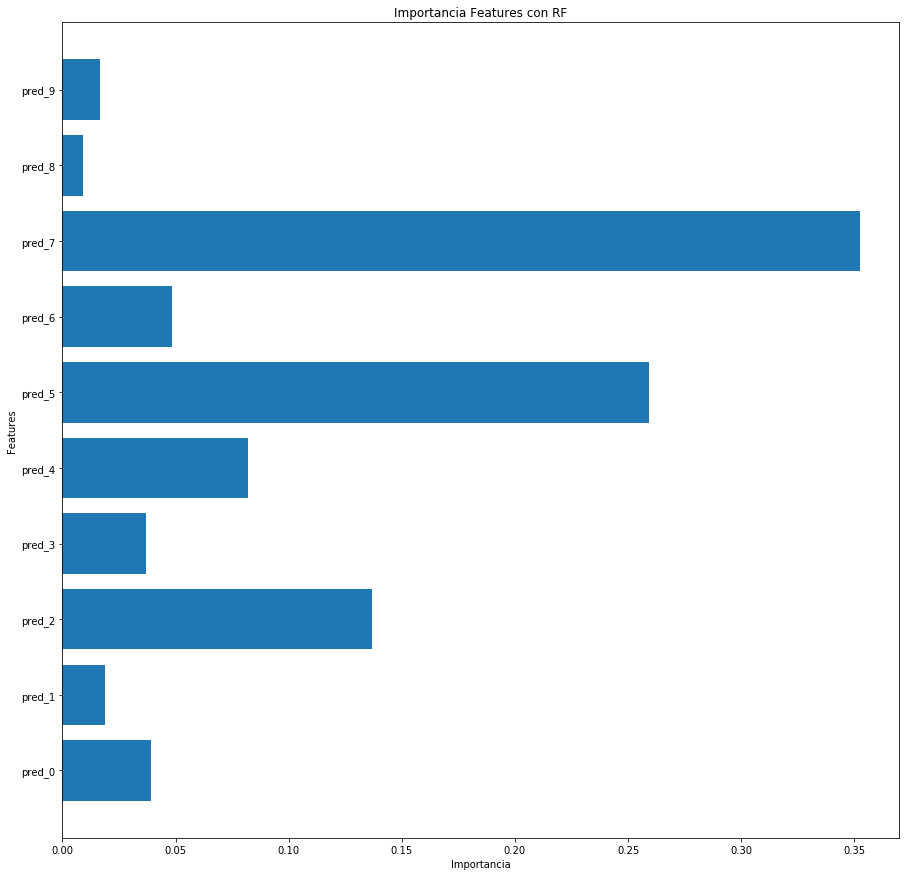

In [41]:
plt.figure(figsize = (15,15))
plt.barh(RF_train.columns, model_RF.feature_importances_)
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.title('Importancia Features con RF')
plt.show()

# Se genera el archivo para subir a Kaggle

In [31]:
test_set = pd.read_csv("test_set_xgb.csv")

In [32]:
test_set.columns

Index(['id', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio',
       'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'anio_publ'],
      dtype='object')

In [33]:
X_test_set = test_set.loc[:, test_set.columns != 'id']

## Armo el DF con las predicciones de test

In [34]:
RF_test_set = pd.DataFrame(index = test_set.index.copy())

In [35]:
for i in range(n):
    current_price_pred = xgb_created[i].predict(X_test_set)
    RF_test_set['pred_{}'.format(i)] = current_price_pred
RF_test_set.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,5662365.500,5404562.500,6.409374e+06,5.287995e+06,7.504102e+06,7046311.00,5.884945e+06,8016892.500,5321656.500,6.893730e+06
1,910470.250,1444256.375,8.033089e+05,8.540992e+05,1.726592e+06,1192132.00,1.495719e+06,1291154.375,2781429.250,1.205634e+06
2,1863433.375,2804849.750,3.261878e+06,1.810418e+06,2.507108e+06,2671923.75,2.736235e+06,1229542.125,1991713.625,2.420992e+06
3,1428380.250,1706897.125,1.365380e+06,2.303738e+06,1.253487e+06,1402017.75,1.967199e+06,1830954.125,2650211.750,1.306691e+06
4,940762.125,983711.125,4.962658e+05,7.801016e+05,4.593129e+05,914339.50,1.346190e+05,1181051.250,757288.750,6.762069e+05


In [36]:
pred_a_kaggle = model_RF.predict(RF_test_set)

In [37]:
df_a_kaggle = pd.DataFrame()
df_a_kaggle['id'] = test_set['id']
df_a_kaggle['target'] = pred_a_kaggle
df_a_kaggle.head()

,id,target
0,4941,6.670484e+06
1,51775,1.166202e+06
2,115253,2.250235e+06
3,299321,1.714692e+06
4,173570,7.385834e+05


In [38]:
df_a_kaggle.to_csv("subir_a_kaggle", header = True, index = False)